In [1]:
from pyoxigraph import *
from sklearn.covariance import OAS
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from utils import *
from Ressources import *
from Ontology import *
from decomposition import *
from pprint import pprint
from itertools import combinations

/home/sam/github/EmbedAlign/embed/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [3]:
def embed_label(target_phrase, sentence):
    
    encoded = tokenizer(sentence, return_tensors="pt", add_special_tokens=False)
    sent_tokens = tokenizer.convert_ids_to_tokens(encoded["input_ids"][0])
    target_tokens = tokenizer.tokenize(target_phrase)
    target_positions = []
    for i in range(len(sent_tokens) - len(target_tokens) + 1):
        if sent_tokens[i : i + len(target_tokens)] == target_tokens:
            target_positions.extend(range(i, i + len(target_tokens)))
    if len(target_positions) == 0:
        raise ValueError(f"Phrase '{target_phrase}' not found in tokenized sentence.")
    with torch.no_grad():
        outputs = model(**encoded)
    hidden = outputs.last_hidden_state
    word_embedding = hidden[0, target_positions, :].mean(dim=0)

    return word_embedding

def oas(word, sentences):
    embeddings = [embed_label(word, s) for s in sentences]
    stacked = torch.stack(embeddings)
    data = np.array(embeddings)
    oas = OAS()
    return stacked, oas.fit(data)

def fit_pca(oas : OAS):
    var = oas.covariance_
    var_t = torch.from_numpy(var).float()
    M, D, V = torch.linalg.svd(var_t)
    return V[:2].T.cpu().numpy()

def project_mean_and_cov(mu: torch.Tensor, cov: torch.Tensor, W: torch.Tensor):
    mu_2d = W.T @ mu
    cov_2d = W.T @ cov @ W
    return mu_2d, cov_2d

def get_ellipsis(word : str, sentences : list):
    embeddings, oac = oas(word, sentences)
    mean = embeddings.mean(dim=0).cpu().numpy()
    pca = fit_pca(oac)
    return project_mean_and_cov(mean, oac.covariance_, pca)

def covariance_to_ellipse_params(cov_2d: torch.Tensor, n_std=1.0):
    eigvals, eigvecs = torch.linalg.eigh(cov_2d)
    idx = torch.argsort(eigvals, descending=True)
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    width, height = 2 * n_std * torch.sqrt(eigvals)
    angle = torch.atan2(eigvecs[1, 0], eigvecs[0, 0]) * (180.0 / torch.pi)
    return width.item(), height.item(), angle.item()


def plot_region(mu_2d, cov_2d, label=None, n_std=1.0, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))

    width, height, angle = covariance_to_ellipse_params(torch.from_numpy(cov_2d), n_std)
    ellipse = Ellipse(
        xy=mu_2d,
        width=width,
        height=height,
        angle=angle,
        edgecolor='blue',
        facecolor = "none",
        alpha=0.4
    )
    ax.add_patch(ellipse)
    ax.scatter(mu_2d[0], mu_2d[1], c='red', s=30)
    if label:
        ax.text(mu_2d[0], mu_2d[1], f" {label}", fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.grid(True)
    return ax

## Initialisation

In [4]:
file = "../test/bfo-core.ttl"
bfo = Ontology.load(file)
hierarchy = bfo.format_hierarchy()
pprint(hierarchy)

{'http://purl.obolibrary.org/obo/BFO_0000001': ['http://purl.obolibrary.org/obo/BFO_0000003',
                                                'http://purl.obolibrary.org/obo/BFO_0000002'],
 'http://purl.obolibrary.org/obo/BFO_0000002': ['http://purl.obolibrary.org/obo/BFO_0000031',
                                                'http://purl.obolibrary.org/obo/BFO_0000020',
                                                'http://purl.obolibrary.org/obo/BFO_0000004'],
 'http://purl.obolibrary.org/obo/BFO_0000003': ['http://purl.obolibrary.org/obo/BFO_0000035',
                                                'http://purl.obolibrary.org/obo/BFO_0000015',
                                                'http://purl.obolibrary.org/obo/BFO_0000011',
                                                'http://purl.obolibrary.org/obo/BFO_0000008'],
 'http://purl.obolibrary.org/obo/BFO_0000004': ['http://purl.obolibrary.org/obo/BFO_0000141',
                                                'http://p

In [5]:
ellipsis_dict = {}
disjoint_pairs = []
for dis in bfo.allDisjointsList:
    iris = [d.iri for d in dis]
    pairs = list(combinations(iris, 2))
    disjoint_pairs += pairs
    
pprint(disjoint_pairs)

[('http://purl.obolibrary.org/obo/BFO_0000142',
  'http://purl.obolibrary.org/obo/BFO_0000146'),
 ('http://purl.obolibrary.org/obo/BFO_0000142',
  'http://purl.obolibrary.org/obo/BFO_0000147'),
 ('http://purl.obolibrary.org/obo/BFO_0000146',
  'http://purl.obolibrary.org/obo/BFO_0000147'),
 ('http://purl.obolibrary.org/obo/BFO_0000009',
  'http://purl.obolibrary.org/obo/BFO_0000018'),
 ('http://purl.obolibrary.org/obo/BFO_0000009',
  'http://purl.obolibrary.org/obo/BFO_0000026'),
 ('http://purl.obolibrary.org/obo/BFO_0000009',
  'http://purl.obolibrary.org/obo/BFO_0000028'),
 ('http://purl.obolibrary.org/obo/BFO_0000018',
  'http://purl.obolibrary.org/obo/BFO_0000026'),
 ('http://purl.obolibrary.org/obo/BFO_0000018',
  'http://purl.obolibrary.org/obo/BFO_0000028'),
 ('http://purl.obolibrary.org/obo/BFO_0000026',
  'http://purl.obolibrary.org/obo/BFO_0000028'),
 ('http://purl.obolibrary.org/obo/BFO_0000008',
  'http://purl.obolibrary.org/obo/BFO_0000011'),
 ('http://purl.obolibrary.org/

[]

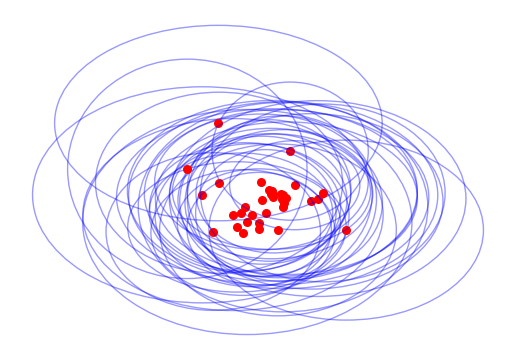

In [6]:
figs, axs = plt.subplots()
axs.set_axis_off()
axs.grid(False)
for c in bfo.named_classes:
    for d in c.disjoints:
        disjoint_pairs.append((c.iri, d.iri))
    label, sentences = c.create_sentences()
    center, cov = get_ellipsis(label, sentences)
    ellipsis_dict[c.iri] = center, cov
    plot_region(center, cov, n_std=2.0, ax=axs)
plt.plot()

## Optimization

In [7]:
import time
start_time = time.time()
optimized = optimize_hierarchy_adaptive(ellipsis_dict,  
                                        bfo.format_hierarchy(), 
                                        disjoint_pairs, 
                                        lr = 5e-2,
                                        lr_factor = 0.5,
                                        target_loss=0.5)

print(f"runtime : {time.time() - start_time}")

[step 200] loss = 1328.4677 | lr = 0.050000
[step 400] loss = 470.2564 | lr = 0.050000
[step 600] loss = 217.6419 | lr = 0.050000
[step 800] loss = 117.6916 | lr = 0.050000
[step 1000] loss = 69.7594 | lr = 0.050000
[step 1200] loss = 44.5039 | lr = 0.050000
[step 1400] loss = 29.4888 | lr = 0.050000
[step 1600] loss = 20.3783 | lr = 0.050000
[step 1800] loss = 14.6463 | lr = 0.050000
[step 2000] loss = 10.9216 | lr = 0.050000
[step 2200] loss = 8.4529 | lr = 0.050000
[step 2400] loss = 6.8082 | lr = 0.050000
[step 2600] loss = 5.6403 | lr = 0.050000
[step 2800] loss = 4.8347 | lr = 0.050000
[step 3000] loss = 4.2642 | lr = 0.050000
[step 3200] loss = 3.8624 | lr = 0.050000
[step 3400] loss = 3.5778 | lr = 0.050000
[step 3600] loss = 3.3787 | lr = 0.050000
[step 3800] loss = 3.2326 | lr = 0.050000
[step 4000] loss = 3.1297 | lr = 0.050000
[step 4200] loss = 3.0474 | lr = 0.050000
[step 4400] loss = 2.9834 | lr = 0.050000
[step 4600] loss = 2.9285 | lr = 0.050000
[step 4800] loss = 2.87

## Metrics


In [12]:
def check_containment(child, parent):
    mu_c, mu_p = child.mu, parent.mu
    Sigma_c, Sigma_p = child.cov, parent.cov
    A = torch.linalg.solve(Sigma_p, Sigma_c)
    eigvals = torch.linalg.eigvalsh(A)
    lambda_axes = torch.max(eigvals)
    delta = mu_c - mu_p
    lambda_shift = delta @ torch.linalg.solve(Sigma_p, delta)
    return (lambda_axes + lambda_shift).item() <= 1.0

def evaluate_containment(ellipses, hierarchy):
    y_true = []
    y_pred = []

    for parent, children in hierarchy.items():
        for child in children:
            E_p = ellipses[parent]
            E_c = ellipses[child]
            y_true.append(1)
            if check_containment(E_c, E_p):
                y_pred.append(1)
            else:
                y_pred.append(0)

    return y_true, y_pred


In [13]:
def check_disjoint(E1, E2, eps=0.1):
    dist = torch.norm(E1.mu - E2.mu)
    r1, r2 = E1.bounding_radius, E2.bounding_radius
    return dist.item() >= (r1 + r2 + eps)

def evaluate_disjointness(ellipses, disjoint_pairs):
    y_true = []
    y_pred = []

    for a, b in disjoint_pairs:
        y_true.append(1)
        y_pred.append(1 if check_disjoint(ellipses[a], ellipses[b]) else 0)

    return y_true, y_pred


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

yt_c, yp_c = evaluate_containment(optimized, hierarchy)

print("Containment accuracy:", accuracy_score(yt_c, yp_c))
print("Containment precision:", precision_score(yt_c, yp_c))
print("Containment recall:", recall_score(yt_c, yp_c))

yt_d, yp_d = evaluate_disjointness(optimized, disjoint_pairs)
print("Disjoint accuracy:", accuracy_score(yt_d, yp_d))
print("Disjoint precision:", precision_score(yt_d, yp_d))
print("Disjoint recall:", recall_score(yt_d, yp_d))


Containment accuracy: 1.0
Containment precision: 1.0
Containment recall: 1.0
Disjoint accuracy: 1.0
Disjoint precision: 1.0
Disjoint recall: 1.0
